In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
import time
from datetime import datetime
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("husl")
sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# get_ipython().run_line_magic('matplotlib', 'inline')

In [ ]:
from google.colab import files
upload = files.upload()

Saving mmm_pystan_kate_tochkaa.xlsx to mmm_pystan_kate_tochkaa.xlsx


In [ ]:
import io
df = pd.read_excel(io.BytesIO(upload['mmm_pystan_kate_tochkaa.xlsx']))
# формат для отображения float
pd.options.display.float_format = '{:.2f}'.format
df.head(3)

,wk_strt_dt,yr_nbr,seas_num_week_year,seas_sin_week_year,seas_cos_week_year,seas_sin4p_week_year,seas_cos4p_week_year,seas_jan,seas_feb,seas_march,seas_apr,seas_may,seas_june,seas_july,seas_aug,seas_sept,seas_oct,seas_nov,seas_dec,Unnamed: 19,mdip_paid,mdip_OLV,mdip_Media,mdip_OOH,mdip_TV,mdsp_paid,mdsp_OLV,mdsp_Media,mdsp_OOH,mdsp_TV,sales,me_cbr
0,2018-12-31,2019.00,1.00,0.12,0.99,0.24,0.97,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,693371.00,0.00,0.00,0.00,347.04,7336490.00,0.00,0.00,0.00,22120730.00,2233939.00,7.75
1,2019-01-07,2019.00,2.00,0.24,0.97,0.46,0.89,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,965736.00,0.00,0.00,0.00,507.18,9344721.00,0.00,0.00,0.00,22120730.00,3477567.00,7.75
2,2019-01-14,2019.00,3.00,0.35,0.94,0.66,0.75,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,982702.00,0.00,0.00,0.00,484.75,9611630.00,0.00,0.00,0.00,22120730.00,3731286.00,7.75


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   wk_strt_dt            174 non-null    datetime64[ns]
 1   yr_nbr                174 non-null    float64       
 2   seas_num_week_year    174 non-null    float64       
 3   seas_sin_week_year    174 non-null    float64       
 4   seas_cos_week_year    174 non-null    float64       
 5   seas_sin4p_week_year  174 non-null    float64       
 6   seas_cos4p_week_year  174 non-null    float64       
 7   seas_jan              174 non-null    float64       
 8   seas_feb              174 non-null    float64       
 9   seas_march            174 non-null    float64       
 10  seas_apr              174 non-null    float64       
 11  seas_may              174 non-null    float64       
 12  seas_june             174 non-null    float64       
 13  seas_july           

In [ ]:
# 1. media variables
# media impression
mdip_cols=[col for col in df.columns if 'mdip_' in col]
# media spending
mdsp_cols=[col for col in df.columns if 'mdsp_' in col]

In [ ]:
# 2. control variables
# macro economics variables
me_cols = [col for col in df.columns if 'me_' in col]
# store count variables
#st_cols = ['st_ct']
# markdown/discount variables
#mrkdn_cols = [col for col in df.columns if 'mrkdn_' in col]
# holiday variables
#hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]
#base_vars = me_cols+st_cols+mrkdn_cols+hldy_cols+seas_cols
base_vars = me_cols+seas_cols

In [ ]:
# 3. sales variables
sales_cols =['sales']

df[['wk_strt_dt']+mdip_cols+['sales']].head()

,wk_strt_dt,mdip_paid,mdip_OLV,mdip_Media,mdip_OOH,mdip_TV,sales
0,2018-12-31,693371.00,0.00,0.00,0.00,347.04,2233939.00
1,2019-01-07,965736.00,0.00,0.00,0.00,507.18,3477567.00
2,2019-01-14,982702.00,0.00,0.00,0.00,484.75,3731286.00
3,2019-01-21,962363.00,0.00,0.00,0.00,542.76,3712884.00
4,2019-01-28,982433.00,0.00,0.00,0.00,519.33,3606410.00


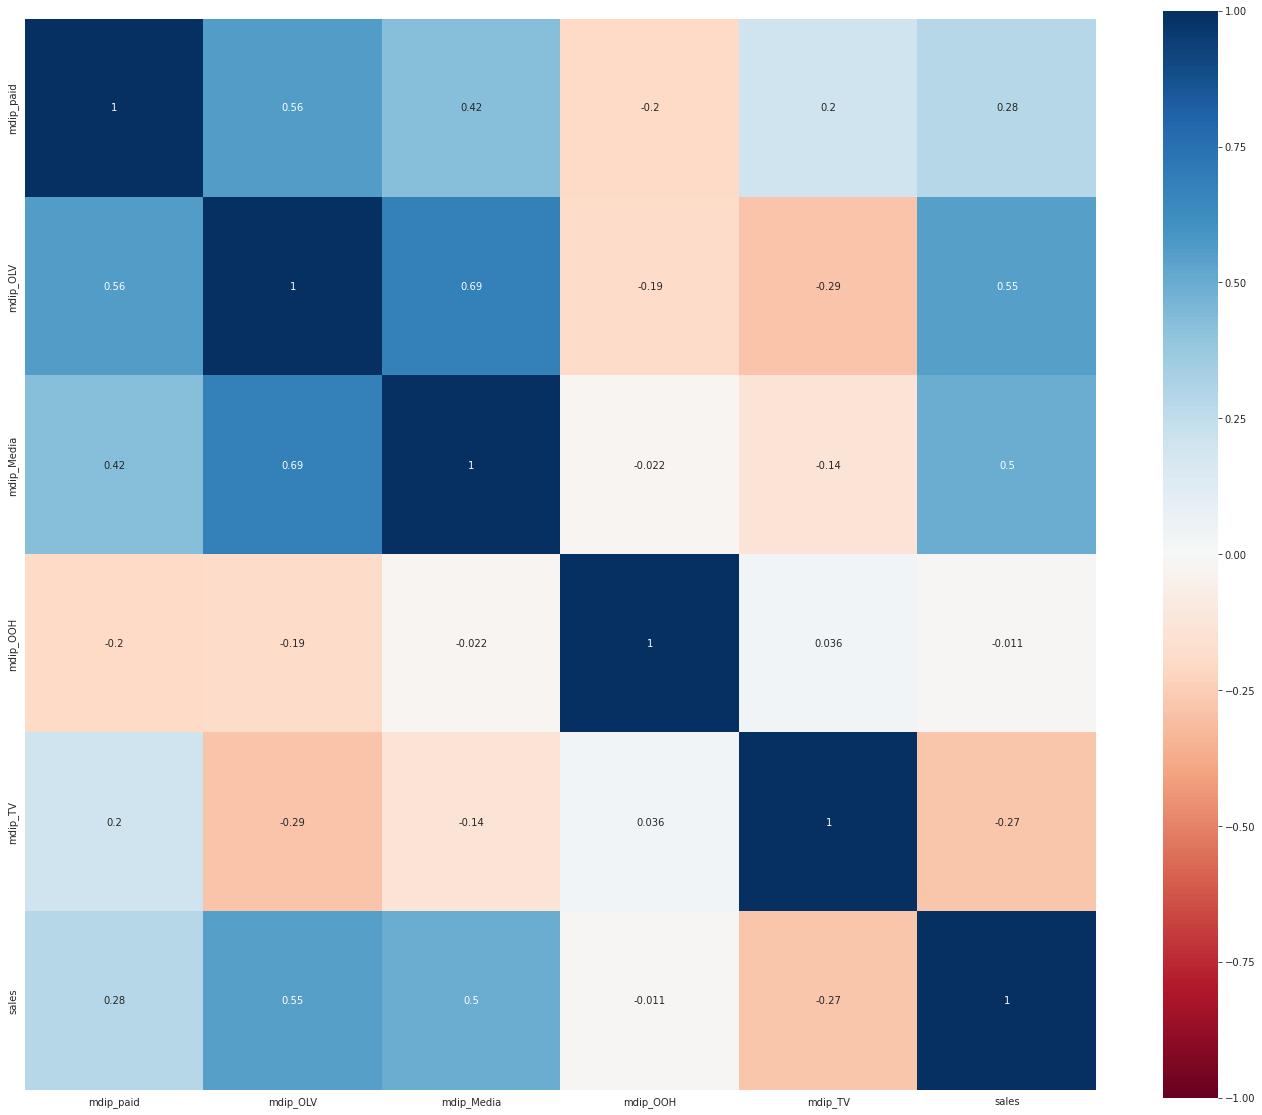

In [ ]:
# EDA - correlation, distribution plots
plt.figure(figsize=(24,20))
sns.heatmap(df[mdip_cols+['sales']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

<Figure size 3600x3600 with 0 Axes>

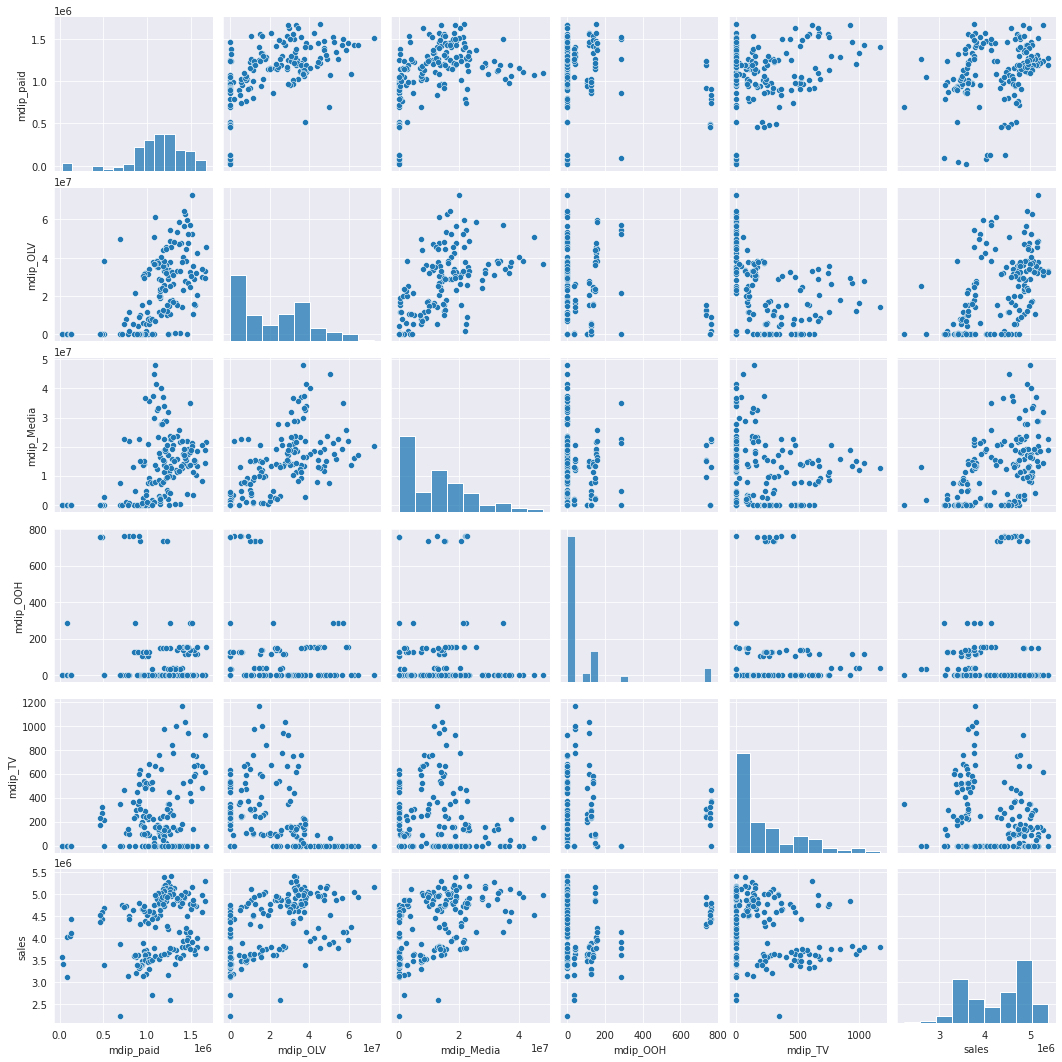

In [ ]:
plt.figure(figsize=(50,50))
sns.pairplot(df[mdip_cols+['sales']], vars=mdip_cols+['sales'])

In [ ]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)

    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight

    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

In [ ]:
def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict,
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns:
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

Text(0.5, 1.0, 'Adstock Parameter: Decay')

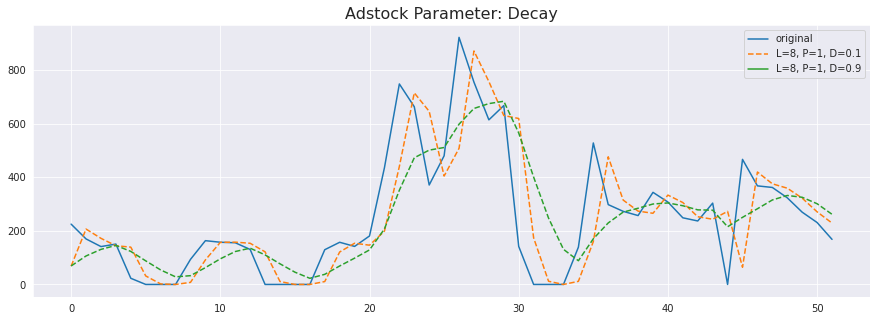

In [ ]:
#plot adstock with varying decay
fig, ax = plt.subplots(figsize=(15,5))
psets = [
     [8, 1, 0.1],
     [8, 1, 0.9]
 ]
xm = df['mdip_TV'].values
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
for i in range(len(psets)):
     p = psets[i]
     L, P, D = p[0], p[1], p[2]
     xm_adstocked = apply_adstock(xm, L, P, D)
     sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax,
                  label='L=%d, P=%d, D=%.1f'%(L, P, D))
     ax.lines[i+1].set_linestyle("--")
ax.set_title('Adstock Parameter: Decay', fontsize=16)

Text(0.5, 1.0, 'Adstock Parameter: Length')

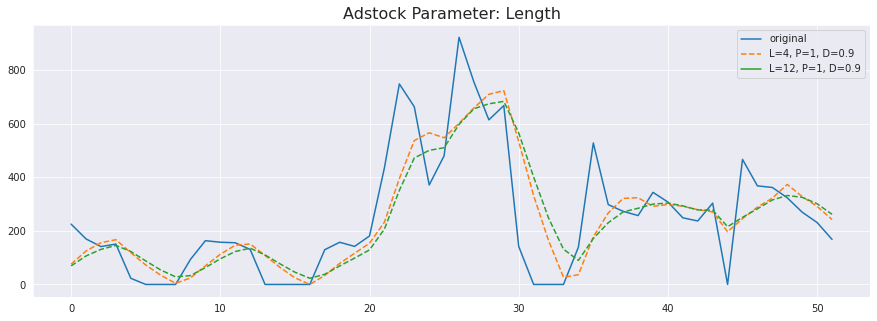

In [ ]:
#plot adstock with varying length
fig, ax = plt.subplots(figsize=(15,5))
psets = [
     [4, 1, 0.9],
     [12, 1, 0.9]
 ]
xm = df['mdip_TV'].values
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
for i in range(len(psets)):
     p = psets[i]
     L, P, D = p[0], p[1], p[2]
     xm_adstocked = apply_adstock(xm, L, P, D)
     sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax,
                  label='L=%d, P=%d, D=%.1f'%(L, P, D))
     ax.lines[i+1].set_linestyle("--")
ax.set_title('Adstock Parameter: Length', fontsize=16)

In [ ]:
# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

Text(0.5, 1.0, 'Hill Function')

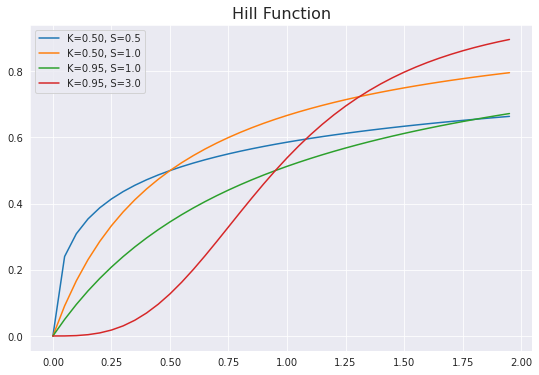

In [ ]:
# # plot hill function with varying K and S
fig, ax = plt.subplots(figsize=(9,6))
psets = [
     [0.5, 0.5],
     [0.5, 1.0],
     [0.95, 1.0],
     [0.95, 3.0]
 ]
xm = np.arange(0,2,0.05)
for i in range(len(psets)):
     p = psets[i]
     ec, slope = p[0], p[1]
     sns.lineplot(x=xm, y=hill_transform(xm, ec, slope), ax=ax,
                  label='K=%.2f, S=%.1f'%(ec, slope))
     #ax.lines[i+1].set_linestyle("--")
ax.set_title('Hill Function', fontsize=16)

In [ ]:
# 2. Model Implementation
# The model is built in a stacked way. Three models are trained:
# - Control Model
# - Marketing Mix Model
# - Diminishing Return Model

# 2.1 Control Model / Base Sales Model
import pystan
import os
#os.environ['CC'] = 'gcc-10'
#os.environ['CXX'] = 'g++-10'


In [ ]:
# helper functions
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns:
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns:
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

In [ ]:
import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data

In [ ]:
# mean-centralize: sales, numeric base_vars
df_ctrl, sc_ctrl = mean_center_trandform(df, ['sales']+me_cols)
df_ctrl = pd.concat([df_ctrl, df[seas_cols]], axis=1)

# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]
X1 = df_ctrl[pos_vars].values

# variables may have either positive or negtive impact on sales: seasonality
pn_vars = seas_cols
X2 = df_ctrl[pn_vars].values

In [ ]:
ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars),
    'K2': len(pn_vars),
    'X1': X1,
    'X2': X2,
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y;
}
parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}
model {
  // Define the priors
  beta1 ~ normal(0, 1);
  beta2 ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''


In [ ]:
sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a396b59aabedfaa132f3a814776a219f NOW.
INFO:pystan:OS: linux, Python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0], Cython 0.29.30


Compiling /tmp/pystan_9vel1m8k/stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_8917453961236481458.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_9vel1m8k/stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_8917453961236481458.pyx
building 'stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_8917453961236481458' extension
creating /tmp/pystan_9vel1m8k/tmp
creating /tmp/pystan_9vel1m8k/tmp/pystan_9vel1m8k
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_9vel1m8k -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/usr/local/lib/python3.7/dist-packages/pystan/stan/lib/stan_math -I/usr/local/lib/python3.7/dist-packages/pystan

In [ ]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars,
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars']
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

In [ ]:
base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', mean_absolute_percentage_error(df['sales'], df['base_sales']))

mape:  13.784583723400257


In [ ]:
np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
save_json(base_sales_model, 'ctrl_model.json')
df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values

In [ ]:
# 2.2 Marketing Mix Model
df_mmm, sc_mmm = mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag,
    'num_media': num_media,
    'X_media': X_media,
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl,
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;

  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  }
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''


In [ ]:
sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6677ffefdee0513f144508ee1783d0c NOW.
INFO:pystan:OS: linux, Python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0], Cython 0.29.30


Compiling /tmp/pystan_b7s_39g4/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_4952035173733088779.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_b7s_39g4/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_4952035173733088779.pyx
building 'stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_4952035173733088779' extension
creating /tmp/pystan_b7s_39g4/tmp
creating /tmp/pystan_b7s_39g4/tmp/pystan_b7s_39g4
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_b7s_39g4 -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/usr/local/lib/python3.7/dist-packages/pystan/stan/lib/stan_math -I/usr/local/lib/python3.7/dist-packages/pystan

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag,
                media_vars=mdip_cols, ctrl_vars=['base_sales'],
                extract_param_list=True):
    mmm = {}

    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()

    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag,
                media_vars=mdip_cols, ctrl_vars=['base_sales'])
save_json(mmm, 'mmm1.json')

In [ ]:
# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

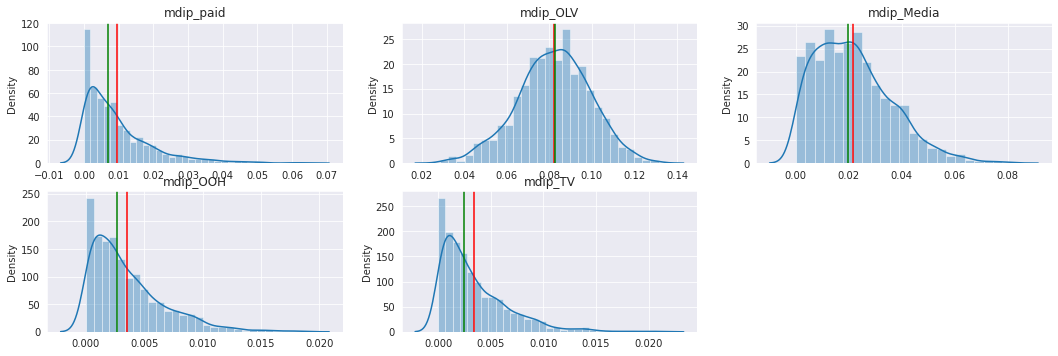

In [ ]:
f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

In [ ]:
# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df, original_sales=df['sales']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor:
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']

    print('rmse (log-log model): ',
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ',
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

In [ ]:
# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

In [ ]:
mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)


rmse (log-log model):  0.06383829899481508
mape (multiplicative model):  7.827462002267726


In [ ]:
mc_df.to_csv('mc_df1.csv', index=False)
save_json(adstock_params, 'adstock_params1.json')
pd.concat([
    pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
    pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
], axis=1).to_csv('mc_pct_df1.csv')

In [ ]:
# 2.3 Diminishing Return Model
def create_hill_model_data(df, mc_df, adstock_params, media):
    y = mc_df['mdip_'+media].values
    L, P, D = adstock_params[media]['L'], adstock_params[media]['P'], adstock_params[media]['D']
    x = df['mdsp_'+media].values
    x_adstocked = apply_adstock(x, L, P, D)
    # centralize
    mu_x, mu_y = x_adstocked.mean(), y.mean()
    sc = {'x': mu_x, 'y': mu_y}
    x = x_adstocked/mu_x
    y = y/mu_y

    model_data = {
        'N': len(y),
        'y': y,
        'X': x
    }
    return model_data, sc

model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // regression coefficient
  real<lower=0> beta_hill;
  // ec50 and slope for Hill function of the media
  real<lower=0,upper=1> ec;
  real<lower=0> slope;
}
transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}
model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(mu, sqrt(noise_var));
}
'''

# pipeline for training one hill model for a media channel
def train_hill_model(df, mc_df, adstock_params, media, sm):
    '''
    params:
    df: original data
    mc_df: media contribution df derived from MMM
    adstock_params: adstock parameter dict output by MMM
    media: 'dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem'
    sm: stan model object
    returns:
    a dict of model data, scaler, parameters
    '''
    data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    fit = sm.sampling(data=data, iter=2000, chains=4)
    fit_result = fit.extract()
    hill_model = {
        'beta_hill_list': fit_result['beta_hill'].tolist(),
        'ec_list': fit_result['ec'].tolist(),
        'slope_list': fit_result['slope'].tolist(),
        'sc': sc,
        'data': {
            'X': data['X'].tolist(),
            'y': data['y'].tolist(),
        }
    }
    return hill_model

# extract params by mean or median
# almost no difference, choose either one
def extract_hill_model_params(hill_model, method='mean'):
    if method=='mean':
        hill_model_params = {
            'beta_hill': np.mean(hill_model['beta_hill_list']),
            'ec': np.mean(hill_model['ec_list']),
            'slope': np.mean(hill_model['slope_list'])
        }
    elif method=='median':
        hill_model_params = {
            'beta_hill': np.median(hill_model['beta_hill_list']),
            'ec': np.median(hill_model['ec_list']),
            'slope': np.median(hill_model['slope_list'])
        }
    return hill_model_params

def hill_model_predict(hill_model_params, x):
    beta_hill, ec, slope = hill_model_params['beta_hill'], hill_model_params['ec'], hill_model_params['slope']
    y_pred = beta_hill * hill_transform(x, ec, slope)
    return y_pred

def evaluate_hill_model(hill_model, hill_model_params):
    x = np.array(hill_model['data']['X'])
    y_true = np.array(hill_model['data']['y']) * hill_model['sc']['y']
    y_pred = hill_model_predict(hill_model_params, x) * hill_model['sc']['y']
    print('mape on original data: ',
         mean_absolute_percentage_error(y_true, y_pred))
    return y_true, y_pred

In [ ]:
# train hill models for all media channels
sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
hill_models = {}



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6631bebabc4f2ed3fbd67294af2f616d NOW.
INFO:pystan:OS: linux, Python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0], Cython 0.29.30


Compiling /tmp/pystan_y2ttw7e0/stanfit4anon_model_6631bebabc4f2ed3fbd67294af2f616d_1187706203169320488.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_y2ttw7e0/stanfit4anon_model_6631bebabc4f2ed3fbd67294af2f616d_1187706203169320488.pyx
building 'stanfit4anon_model_6631bebabc4f2ed3fbd67294af2f616d_1187706203169320488' extension
creating /tmp/pystan_y2ttw7e0/tmp
creating /tmp/pystan_y2ttw7e0/tmp/pystan_y2ttw7e0
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_y2ttw7e0 -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/usr/local/lib/python3.7/dist-packages/pystan/stan/lib/stan_math -I/usr/local/lib/python3.7/dist-packages/pystan

In [ ]:
to_train = ['paid', 'OLV', 'Media', 'OOH', 'TV']
#to_train = ['paid']

In [ ]:
for media in to_train:
    print('training for media: ', media)
    hill_model = train_hill_model(df, mc_df, adstock_params, media, sm3) #####поправить исходный датасет чтобы везде были точки а не запятые в колонках mdsp_ (посмотреть как вmdsp_dm)
    hill_models[media] = hill_model

training for media:  paid
training for media:  OLV


training for media:  Media


training for media:  OOH


training for media:  TV


In [ ]:
# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    params1 = extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')

# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)

evaluating media:  paid
mape on original data:  564.3365296343792
evaluating media:  OLV
mape on original data:  nan
evaluating media:  Media
mape on original data:  nan
evaluating media:  OOH
mape on original data:  nan
evaluating media:  TV
mape on original data:  nan


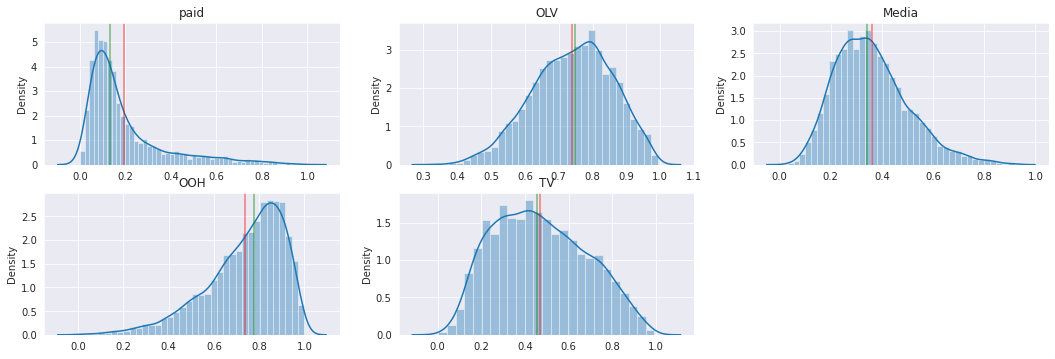

In [ ]:
# plot ec distribution
f = plt.figure(figsize=(18,12))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    x = hill_models[md]['ec_list']
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set_title(md)

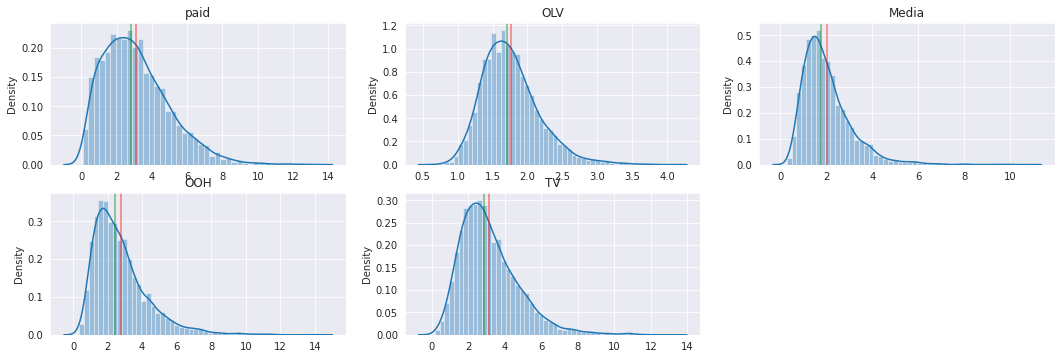

In [ ]:
# plot slope distribution
f = plt.figure(figsize=(18,12))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    x = hill_models[md]['slope_list']
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set_title(md)

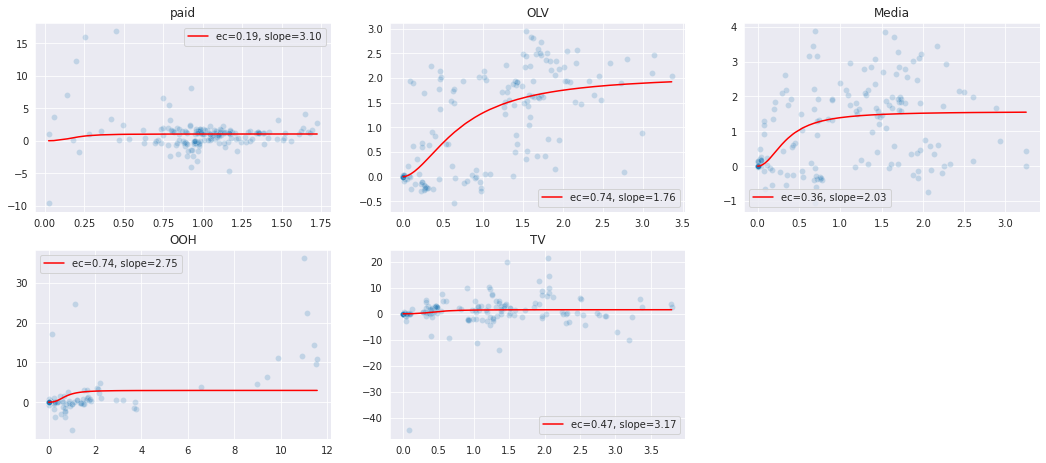

In [ ]:
# plot fitted hill function
f = plt.figure(figsize=(18,16))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    hm = hill_models[md]
    hmp = hill_model_params_mean[md]
    x, y = hm['data']['X'], hm['data']['y']
    #mu_x, mu_y = hm['sc']['x'], hm['sc']['y']
    ec, slope = hmp['ec'], hmp['slope']
    x_sorted = np.array(sorted(x))
    y_fit = hill_model_predict(hmp, x_sorted)
    ax = sns.scatterplot(x=x, y=y, alpha=0.2)
    ax = sns.lineplot(x=x_sorted, y=y_fit, color='r',
                 label='ec=%.2f, slope=%.2f'%(ec, slope))
    ax.set_title(md)

In [ ]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df['mdsp_'+md] = x
# ms_df.to_csv('ms_df1.csv', index=False)

# calc overall ROAS of a given period
def calc_roas(mc_df, ms_df, period=None):
    roas = {}
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for i in range(len(md_names)):
        md = md_names[i]
        sp, mc = ms_df['mdsp_'+md], mc_df['mdip_'+md]
        if period is None:
            md_roas = mc.sum()/sp.sum()
        else:
            md_roas = mc[-period:].sum()/sp[-period:].sum()
        roas[md] = md_roas
    return roas


In [ ]:
# calc weekly ROAS
def calc_weekly_roas(mc_df, ms_df):
    weekly_roas = pd.DataFrame()
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for md in md_names:
        weekly_roas[md] = mc_df['mdip_'+md]/ms_df['mdsp_'+md]
    weekly_roas.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return weekly_roas

roas_1y = calc_roas(mc_df, ms_df, period=52)
weekly_roas = calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)


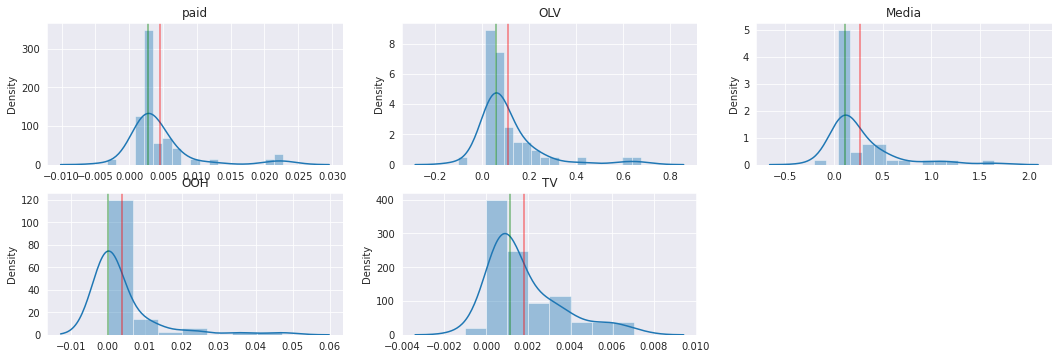

In [ ]:
# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)

In [ ]:
# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:
# Current media contribution: cur_mc = Hill(cur_sp)
# Next-level media contribution next_mc = Hill(next_sp)
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)

In [ ]:
def calc_mroas(hill_model, hill_model_params, period=52):
    '''
    calculate mROAS for a media
    params:
    hill_model: a dict containing model data and scaling factor
    hill_model_params: a dict containing beta_hill, ec, slope
    period: in weeks, the period used to calculate ROAS and mROAS. 52 is last one year.
    return:
    mROAS value
    '''
    mu_x, mu_y = hill_model['sc']['x'], hill_model['sc']['y']
    # get current media spending level over the period specified
    cur_sp = np.array(hill_model['data']['X'])                                    #добавила обертку np.array к hill_model['data']['X'] - без нее была ошибка TypeError: can't multiply sequence by non-int of type 'float' site:stackoverflow.com
    if period is not None:
        cur_sp = cur_sp[-period:]
    cur_mc = sum(hill_model_predict(hill_model_params, cur_sp) * mu_y)
    # next spending level: increase by 1%
    next_sp = cur_sp * 1.01
    # media contribution under next spending level
    next_mc = sum(hill_model_predict(hill_model_params, next_sp) * mu_y)

    # mROAS
    delta_mc = next_mc - cur_mc
    delta_sp = sum(next_sp * mu_x) - sum(cur_sp * mu_x)
    mroas = delta_mc/delta_sp
    return mroas

# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = calc_mroas(hill_model, hill_model_params, period=52)

In [ ]:
roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df
# **ROAS & mROAS**
# 'roas_avg': overall ROAS = total contribution / total spending
# 'roas_mean': mean of weekly ROAS
# 'roas_median': median of weekly ROAS
# 'mroas': mROAS calculated based on increasing current spending level by 1%

,roas_mean,roas_median,mroas,roas_avg
paid,0.00,0.00,0.00,0.00
OLV,0.11,0.06,0.02,0.06
Media,0.27,0.12,0.02,0.13
OOH,0.00,0.00,0.00,0.01
TV,0.00,0.00,0.00,0.00
